# Benchmark SGD Implementations  
In this iPython notebook, we benchmark the Parallel implementaton of SGD against the implementation in SciKit-Learn library. We will use SGD in both cases for regression on synthetic data.   

**Credits**  
The parallel implementation here is based on this paper: Zinkevich, M., Weimer, M., Li, L., & Smola, A. (2010). Parallelized stochastic gradient descent. Advances in Neural …, 1–36. Retrieved from http://papers.nips.cc/paper/4006-parallelized-stochastic-gradient-descent 

## The Dataset  
The dataset will be generated using SciKit-Learn's `make_regression` function.  

In [1]:
from sklearn.datasets import make_regression
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
n_samples = 1000
n_features = 100
seed = 1
effective_rank = 100

In [3]:
X, y = make_regression(n_samples=n_samples, n_features=n_features, 
                       random_state=seed, noise=0.0, effective_rank=effective_rank)

Split the dataset into train and test

In [4]:
from sklearn.cross_validation import ShuffleSplit

In [5]:
for train, test in ShuffleSplit(n=n_samples, n_iter=1, test_size=0.2):
    pass

In [6]:
X_train = X[train]
X_test = X[test]
y_train = y[train]
y_test = y[test]

## SciKit-Learn SGD

In [7]:
from sklearn.linear_model import SGDRegressor

In [8]:
n_iter = 5000

In [9]:
sgd = SGDRegressor(n_iter=n_iter)

In [10]:
%time sgd.fit(X_train, y_train)

CPU times: user 1.14 s, sys: 1.56 ms, total: 1.14 s
Wall time: 1.14 s


SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5000, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [11]:
sgd.score(X_test, y_test)

0.76151435136973511

Train iteratively so get score at each iteration:

In [126]:
scores_base = []
sgd = SGDRegressor(n_iter=1, warm_start=True)
for i in range(n_iter):
    sgd.partial_fit(X_train, y_train)
    scores_base += [sgd.score(X_test, y_test)]

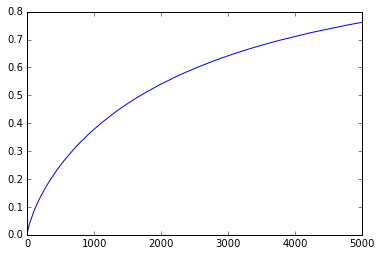

In [127]:
plt.plot(range(len(scores_base)), scores_base)

In [128]:
scores_base[-1]

0.76151753172543668

##  Parallel SGD Simulation
We run multiple simulations of Parallel SGD here

In [97]:
import utils
reload(utils)

<module 'utils' from 'utils.py'>

### Test 1: Split data evenly, synchronize at the end
Simulate running SGD in parallel such that the input data is split evenly amongst the workers. The weights are synchronized once after all workers are done.

In [16]:
n_jobs = 4
%time scores = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1/n_jobs, overlap=False)

CPU times: user 20.6 s, sys: 1min 21s, total: 1min 41s
Wall time: 12.8 s


In [ ]:
utils.plot_scores(scores)

### Test 2: Don't Split data, synchronize at the end
Simulate running SGD in parallel such that all workers have access to all the data. The weights are synchronized once after all workers are done.


4 workers:

In [50]:
n_jobs = 4
%time scores_4 = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1, overlap=True, verbose=True)

CPU times: user 34.6 s, sys: 2min 34s, total: 3min 8s
Wall time: 24.6 s


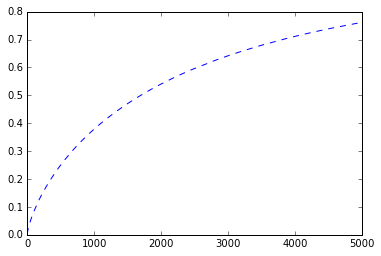

In [59]:
utils.plot_scores(scores_4)

20 workers:

In [52]:
n_jobs = 20
%time scores_20 = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1, overlap=True, verbose=True)

CPU times: user 2min 45s, sys: 12min 18s, total: 15min 3s
Wall time: 1min 59s


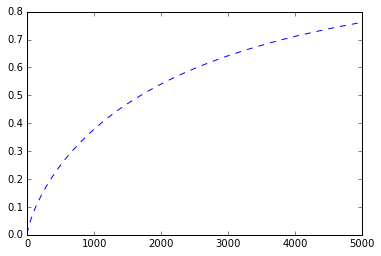

In [57]:
utils.plot_scores(scores_20)

50 workers:

In [54]:
n_jobs = 50
%time scores_50 = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1, overlap=True, verbose=True)

CPU times: user 6min 45s, sys: 30min 30s, total: 37min 15s
Wall time: 4min 52s


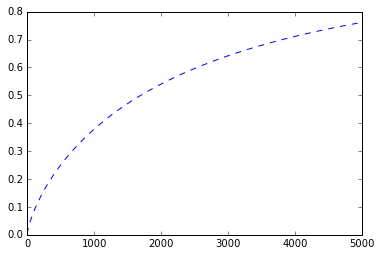

In [58]:
utils.plot_scores(scores_50)

100 workers:

In [68]:
n_jobs = 100
%time scores_100 = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=1, overlap=True, verbose=True)

CPU times: user 13min 19s, sys: 59min 36s, total: 1h 12min 56s
Wall time: 9min 35s


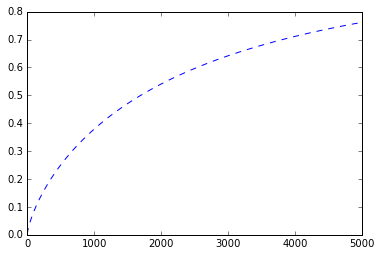

In [69]:
utils.plot_scores(scores_100)

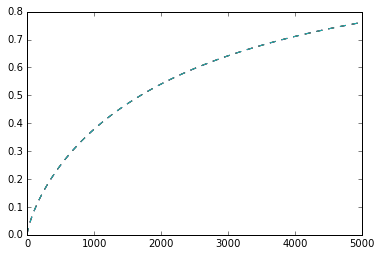

In [70]:
plt.figure(1)
for s in [scores_4, scores_20, scores_50, scores_100]:
    s = np.array(s).T
    plt.plot(range(len(s[-1])), s[-1], '--')

### Test 3: Split data with overlap, synchronize at the end

Each machine has 50% of all data

In [ ]:
n_jobs = 4
%time scores = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=0.5, overlap=True)

In [ ]:
utils.plot_scores(scores)

Each machine has 25% of all data

In [ ]:
n_jobs = 4
%time scores = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, split_per_job=0.25, overlap=True)

In [ ]:
utils.plot_scores(scores)

### Test 4: Dont' split data with overlap, synchronize x times


Synchronize 2 times (including at the end)

In [107]:
reload(utils)

<module 'utils' from 'utils.py'>

In [108]:
n_jobs = 4
n_sync = 2
%time scores_2_sync = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, n_sync=n_sync, split_per_job=1, overlap=True, verbose=True)

CPU times: user 37.3 s, sys: 3min 5s, total: 3min 42s
Wall time: 30.2 s


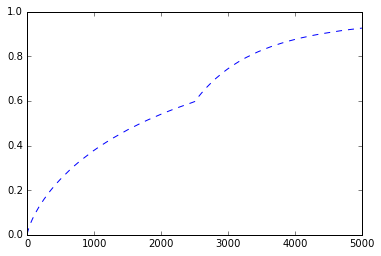

In [112]:
utils.plot_scores(scores_2_sync)

In [109]:
n_jobs = 4
n_sync = 5
%time scores_5_sync = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, n_sync=n_sync, split_per_job=1, overlap=True, verbose=True)

CPU times: user 36.9 s, sys: 3min 2s, total: 3min 39s
Wall time: 29.4 s


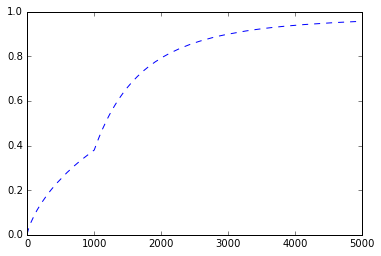

In [113]:
utils.plot_scores(scores_5_sync)

In [117]:
reload(utils)

<module 'utils' from 'utils.py'>

In [118]:
n_jobs = 4
n_sync = 10
%time scores_10_sync = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter, n_jobs, n_sync=n_sync, split_per_job=1, overlap=True, verbose=True)

Synced at iteration: 500
Synced at iteration: 1000
Synced at iteration: 1500
Synced at iteration: 2000
Synced at iteration: 2500
Synced at iteration: 3000
Synced at iteration: 3500
Synced at iteration: 4000
Synced at iteration: 4500
CPU times: user 36.2 s, sys: 2min 56s, total: 3min 32s
Wall time: 28.3 s


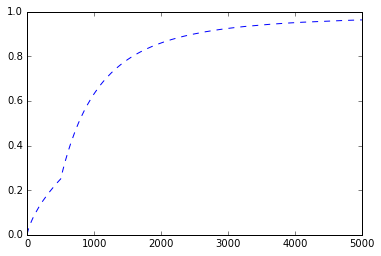

In [119]:
utils.plot_scores(scores_10_sync)

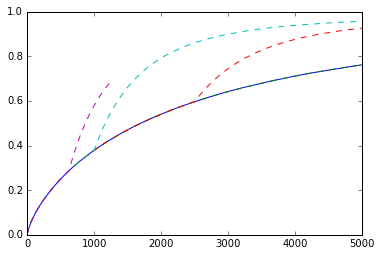

In [135]:
plt.figure(1)
plt.plot(range(len(scores_base)), scores_base)
for s in [scores_4, scores_2_sync, scores_5_sync, scores_10_sync]:
    s = np.array(s).T
    plt.plot(range(len(s[-1])), s[-1], '--')

In [138]:
reload(utils)

<module 'utils' from 'utils.py'>

In [139]:
n_jobs = 4
n_sync = 4
%time scores_try = utils.sim_parallel_sgd(X_train, y_train, X_test, y_test, n_iter/n_jobs, n_jobs, n_sync=n_sync, split_per_job=1, overlap=True, verbose=True)

Synced at iteration: 312
Synced at iteration: 624
Synced at iteration: 936
Synced at iteration: 1248
CPU times: user 8.99 s, sys: 41.8 s, total: 50.8 s
Wall time: 6.83 s


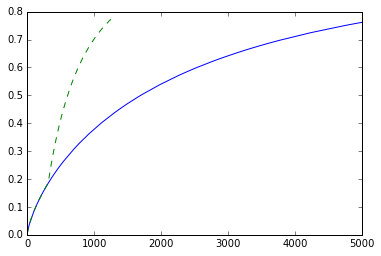

In [140]:
plt.figure(1)
plt.plot(range(len(scores_base)), scores_base)
for s in [scores_try]:
    s = np.array(s).T
    plt.plot(range(len(s[-1])), s[-1], '--')

## Parallel SGD (for real)
Parallel implementation of SGD based on the simulation results from previous section

In [149]:
from multiprocessing import Pool

In [351]:
reload(utils)

<module 'utils' from 'utils.py'>

In [358]:
n_jobs = 1
n_sync = 1
n_iter = 5000/n_jobs/n_sync
data = utils.split_data(X_train, y_train, n_jobs, 1, True)
pool = Pool(processes=n_jobs)

%time sgd = utils.parallel_sgd(pool, SGDRegressor(), n_iter=n_iter, n_jobs=n_jobs, n_sync=n_sync, data=data)

print "Score:", sgd.score(X_test, y_test)

CPU times: user 16.8 ms, sys: 12.5 ms, total: 29.3 ms
Wall time: 1.19 s
Score: 0.761525531409


In [366]:
n_jobs = 2
n_sync = 1
n_iter = 5000/n_jobs
data = utils.split_data(X_train, y_train, n_jobs, 1, True)
pool = Pool(processes=n_jobs)

%time sgd = utils.parallel_sgd(pool, SGDRegressor(), n_iter=n_iter, n_jobs=n_jobs, n_sync=n_sync, data=data)

print "Score:", sgd.score(X_test, y_test)

CPU times: user 23.4 ms, sys: 0 ns, total: 23.4 ms
Wall time: 688 ms
Score: 0.596112275181


In [367]:
n_jobs = 2
n_sync = 2
n_iter = 5000/n_jobs
data = utils.split_data(X_train, y_train, n_jobs, 1, True)
pool = Pool(processes=n_jobs)

%time sgd = utils.parallel_sgd(pool, SGDRegressor(), n_iter=n_iter, n_jobs=n_jobs, n_sync=n_sync, data=data)

print "Score:", sgd.score(X_test, y_test)

CPU times: user 24.4 ms, sys: 15.5 ms, total: 39.9 ms
Wall time: 1.29 s
Score: 0.80883436486


In [361]:
n_jobs = 2
n_sync = 4
n_iter = 5000/n_jobs/n_sync
data = utils.split_data(X_train, y_train, n_jobs, 1, True)
pool = Pool(processes=n_jobs)

%time sgd = utils.parallel_sgd(pool, SGDRegressor(), n_iter=n_iter/n_jobs, n_jobs=n_jobs, n_sync=n_sync, data=data)

print "Score:", sgd.score(X_test, y_test)

CPU times: user 13.9 ms, sys: 8.78 ms, total: 22.6 ms
Wall time: 525 ms
Score: 0.538019406579


In [362]:
n_jobs = 4
n_sync = 1
n_iter = 5000/n_jobs/n_sync
data = utils.split_data(X_train, y_train, n_jobs, 1, True)
pool = Pool(processes=n_jobs)

%time sgd = utils.parallel_sgd(pool, SGDRegressor(), n_iter=n_iter, n_jobs=n_jobs, n_sync=n_sync, data=data)

print "Score:", sgd.score(X_test, y_test)

CPU times: user 5.51 ms, sys: 15.3 ms, total: 20.8 ms
Wall time: 577 ms
Score: 0.427786662004


In [363]:
n_jobs = 4
n_sync = 2
n_iter = 5000/n_jobs/n_sync
data = utils.split_data(X_train, y_train, n_jobs, 1, True)
pool = Pool(processes=n_jobs)

%time sgd = utils.parallel_sgd(pool, SGDRegressor(), n_iter=n_iter, n_jobs=n_jobs, n_sync=n_sync, data=data)

print "Score:", sgd.score(X_test, y_test)

CPU times: user 6.8 ms, sys: 21.1 ms, total: 27.9 ms
Wall time: 703 ms
Score: 0.481886743833


In [364]:
n_jobs = 4
n_sync = 4
n_iter = 5000/n_jobs/n_sync
data = utils.split_data(X_train, y_train, n_jobs, 1, True)
pool = Pool(processes=n_jobs)

%time sgd = utils.parallel_sgd(pool, SGDRegressor(), n_iter=n_iter, n_jobs=n_jobs, n_sync=n_sync, data=data)

print "Score:", sgd.score(X_test, y_test)

CPU times: user 23.9 ms, sys: 13 ms, total: 36.8 ms
Wall time: 828 ms
Score: 0.538018672005


In [365]:
n_jobs = 4
n_sync = 8
n_iter = 5000/n_jobs/n_sync
data = utils.split_data(X_train, y_train, n_jobs, 1, True)
pool = Pool(processes=n_jobs)

%time sgd = utils.parallel_sgd(pool, SGDRegressor(), n_iter=n_iter, n_jobs=n_jobs, n_sync=n_sync, data=data)

print "Score:", sgd.score(X_test, y_test)

CPU times: user 8.25 ms, sys: 52.6 ms, total: 60.9 ms
Wall time: 1.26 s
Score: 0.59574788826
